In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import bs4 as bs
import urllib.request
import nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
import warnings

In [3]:
# Ignore warnings
warnings.filterwarnings(action='ignore')

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Step 1: Data Preparation


In [4]:
# Step 1: Data Preparation
# Scrape text data from a URL
scrapped_data = urllib.request.urlopen("https://en.wikipedia.org/wiki/Machine_learning")
article = scrapped_data.read()
parsed_article = bs.BeautifulSoup(article, 'lxml')
paragraphs = parsed_article.find_all('p')
article_text = ""

for p in paragraphs:
    article_text += p.text

article_text = article_text.lower()
article_text

'machine learning (ml) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions.[1] advances in the field of deep learning have allowed neural networks to surpass many previous approaches in performance.[2]\nml finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine.[3][4] the application of ml to business problems is known as predictive analytics.\nstatistics and mathematical optimization (mathematical programming) methods comprise the foundations of machine learning. data mining is a related field of study, focusing on exploratory data analysis (eda) via unsupervised learning.[6][7]\nfrom a theoretical viewpoint, probably approximately correct (pac) learning provides a framework for describing machine learning.\nthe term mach

In [5]:
#optional
#article_text = 'machine learning (ml) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions.[1] advances in the field of deep learning have allowed neural networks to surpass many previous approaches in performance.[2]\nml finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine.[3][4] the application of ml to business problems is known as predictive analytics.\nstatistics and mathematical optimization (mathematical programming) methods comprise the foundations of machine learning. data mining is a related field of study, focusing on exploratory data analysis (eda) via unsupervised learning.[6][7]\nfrom a theoretical viewpoint, probably approximately correct (pac) learning provides a framework for describing machine learning.\nthe term machine learning was coined in 1959 by arthur samuel, an ibm employee and pioneer in the field of computer gaming and artificial intelligence.'

In [6]:
# Clean and preprocess the text
sentences = re.sub('[^A-Za-z0-9]+', ' ', article_text)  # Remove special characters
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()  # Remove single-letter words
sentences = sentences.lower()  # Convert to lowercase


In [7]:
# Tokenize sentences and words
all_sent = nltk.sent_tokenize(sentences)
all_words = [nltk.word_tokenize(sent) for sent in all_sent]

In [8]:
# Remove stopwords from tokenized words
for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]

## Step 2: Generate Training Data

In [9]:
# Step 2: Generate Training Data
# Prepare context-target pairs for CBOW (context window of 2)
data_for_cbow = []
window_size = 2   # Size of the context window

for sentence in all_words:
    for i in range(window_size, len(sentence) - window_size):
        context = []
        # Collect context words within the window size
        for j in range(-window_size, window_size + 1):
            if j != 0:  # Skip the target word itself
                context.append(sentence[i + j])
        target = sentence[i]
        data_for_cbow.append((context, target))



In [10]:

# Display the first 5 context-target pairs
print("First 5 context-target pairs:")
for pair in data_for_cbow[:5]:
    print(f"Context: {pair[0]}, Target: {pair[1]}")


First 5 context-target pairs:
Context: ['machine', 'learning', 'field', 'study'], Target: ml
Context: ['learning', 'ml', 'study', 'artificial'], Target: field
Context: ['ml', 'field', 'artificial', 'intelligence'], Target: study
Context: ['field', 'study', 'intelligence', 'concerned'], Target: artificial
Context: ['study', 'artificial', 'concerned', 'development'], Target: intelligence


In [11]:

# Step 3: Train CBOW Model
# Build the Word2Vec model with CBOW architecture
#model_cbow = Word2Vec(sentences=all_words, vector_size=1000, window=window_size, min_count=1, sg=0)

flattened_sentences = [[*context, target] for context, target in data_for_cbow]
model_cbow = Word2Vec(sentences=flattened_sentences, vector_size=52, window=window_size, min_count=1, sg=0)

# Access the vocabulary using .key_to_index (Gensim 4.0+)
vocabulary = model_cbow.wv.key_to_index
print("Vocabulary:", vocabulary)


Vocabulary: {'learning': 0, 'machine': 1, 'data': 2, 'model': 3, 'training': 4, 'algorithms': 5, 'used': 6, 'set': 7, 'artificial': 8, 'models': 9, 'algorithm': 10, 'ai': 11, 'methods': 12, 'systems': 13, 'also': 14, 'based': 15, 'example': 16, 'examples': 17, 'neural': 18, 'field': 19, 'classification': 20, 'supervised': 21, 'input': 22, 'many': 23, 'theory': 24, 'often': 25, 'one': 26, 'unsupervised': 27, 'feature': 28, 'using': 29, 'networks': 30, 'called': 31, 'may': 32, 'techniques': 33, 'knowledge': 34, 'process': 35, 'system': 36, 'trained': 37, 'decision': 38, 'analysis': 39, 'network': 40, 'problems': 41, 'new': 42, 'compression': 43, 'predictions': 44, 'performance': 45, 'time': 46, 'computer': 47, 'human': 48, 'function': 49, 'regression': 50, 'research': 51, 'output': 52, 'represented': 53, 'approaches': 54, 'intelligence': 55, 'neurons': 56, 'features': 57, 'rule': 58, 'including': 59, 'mining': 60, 'perform': 61, 'image': 62, 'given': 63, 'signal': 64, 'known': 65, 'learn

In [12]:

# Step 4: Output Similar Words
# Find and display similar words for a given word
test_word = 'field'
if test_word in model_cbow.wv:
    similar_words = model_cbow.wv.most_similar(test_word)
    print(f"\nWords similar to '{test_word}':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
else:
    print(f"'{test_word}' not found in vocabulary.")



Words similar to 'field':
model: 0.9910650253295898
data: 0.9905507564544678
systems: 0.9902727007865906
example: 0.9900239109992981
learning: 0.9898157715797424
theory: 0.9893614053726196
one: 0.9891684651374817
models: 0.9889301061630249
set: 0.9886974692344666
examples: 0.9883818030357361


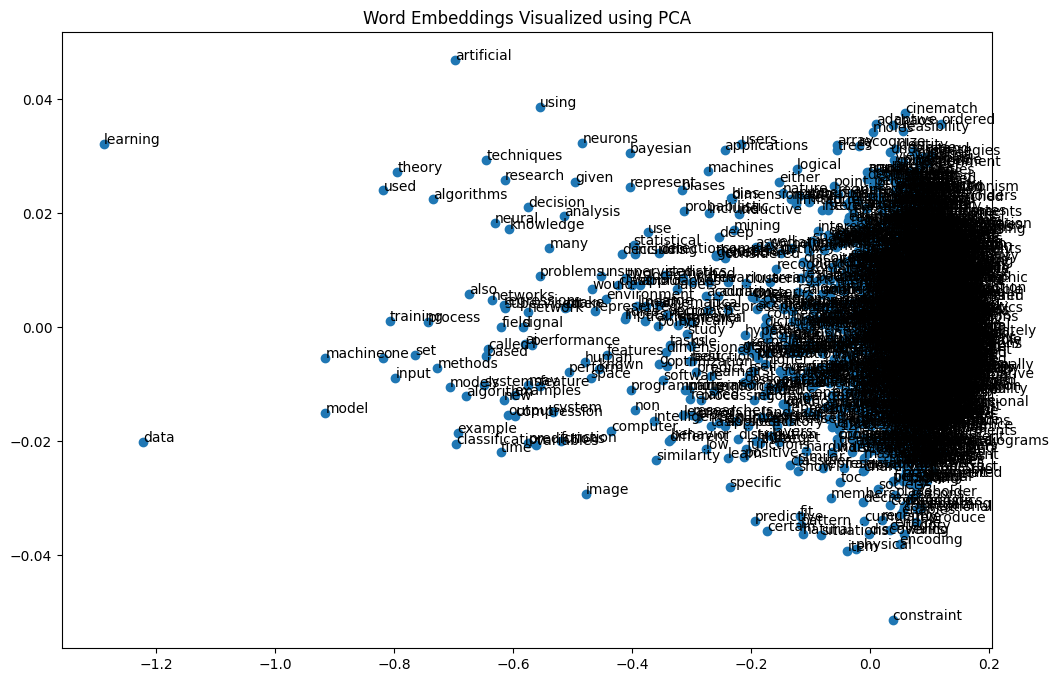

In [13]:
# Step 5: Visualize Word Embeddings
# Prepare for PCA visualization
X = model_cbow.wv.vectors  # Get the word vectors
pca = PCA(n_components=2)  # Create a PCA instance
result = pca.fit_transform(X)  # Fit and transform the vectors

# Plot the 2D PCA projection of the word embeddings
plt.figure(figsize=(12, 8))
plt.scatter(result[:, 0], result[:, 1])
words = list(model_cbow.wv.key_to_index)  # List of words in the vocabulary
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.title("Word Embeddings Visualized using PCA")
plt.show()